In [21]:
import networkx as nx
import numpy as np
from grakel import graph_from_networkx
from scipy.spatial.distance import jensenshannon
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt

In [22]:
# загружаем данные из датасета hard_small, тк на датасете hard все алгоритмы очень долго работают
# поскольку в нем очень много значений

# загружаю данные по официальному примеру с репы grakel
loaded = np.load(f'hard_small.npz', allow_pickle=True)

A_train = list(loaded['tr_adj'])
X_train = loaded['tr_feat']
y_train = loaded['tr_class']
A_test = list(loaded['te_adj'])
X_test = loaded['te_feat']
y_test = loaded['te_class']

G_tr = []
for a, x in zip(A_train, X_train):
    G = nx.from_scipy_sparse_array(a)
    x_tuple = tuple(map(tuple, x))
    nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
    G_tr.append(G)

G_te = []
for a, x in zip(A_test, X_test):
    G = nx.from_scipy_sparse_array(a)
    x_tuple = tuple(map(tuple, x))
    nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
    G_te.append(G)

G_train = graph_from_networkx(G_tr, node_labels_tag='features')
G_train = [g for g in G_train]
y_train = np.argmax(y_train, axis=-1)
G_test = graph_from_networkx(G_te, node_labels_tag='features')
G_test = [g for g in G_test]
y_test = np.argmax(y_test, axis=-1)

G = G_train + G_test
y = np.concatenate((y_train, y_test))

In [24]:
from grakel.kernels import CoreFramework, ShortestPath, GraphletSampling
# ядра
kernels = {
    'Core framework': CoreFramework(normalize=True),
    'Shortest Path': ShortestPath(normalize=True),
    'Graphlet Sampling': GraphletSampling(normalize=True)
}

# применяем ядра
ker_mat = {}
for name, kernel in kernels.items():
    ker_mat[name] = kernel.fit_transform(G)

In [25]:
# методы для подсчета расстояний
distance_methods = {
    'sqrt': lambda k: np.sqrt(np.diag(k)[:, None] + np.diag(k)[None, :] - 2 * k),
    'acos': lambda k: np.arccos(np.clip(k / np.sqrt(np.diag(k)[:, None] * np.diag(k)[None, :]), -1, 1)),
    'inverse': lambda k: 1 - k,
}

In [26]:
# методы для уменьшения размерности
embeddings_methods = {
    "MDS": MDS(n_components=3, dissimilarity="precomputed"),
    "t-SNE": TSNE(n_components=3, metric="precomputed", init='random'),
}

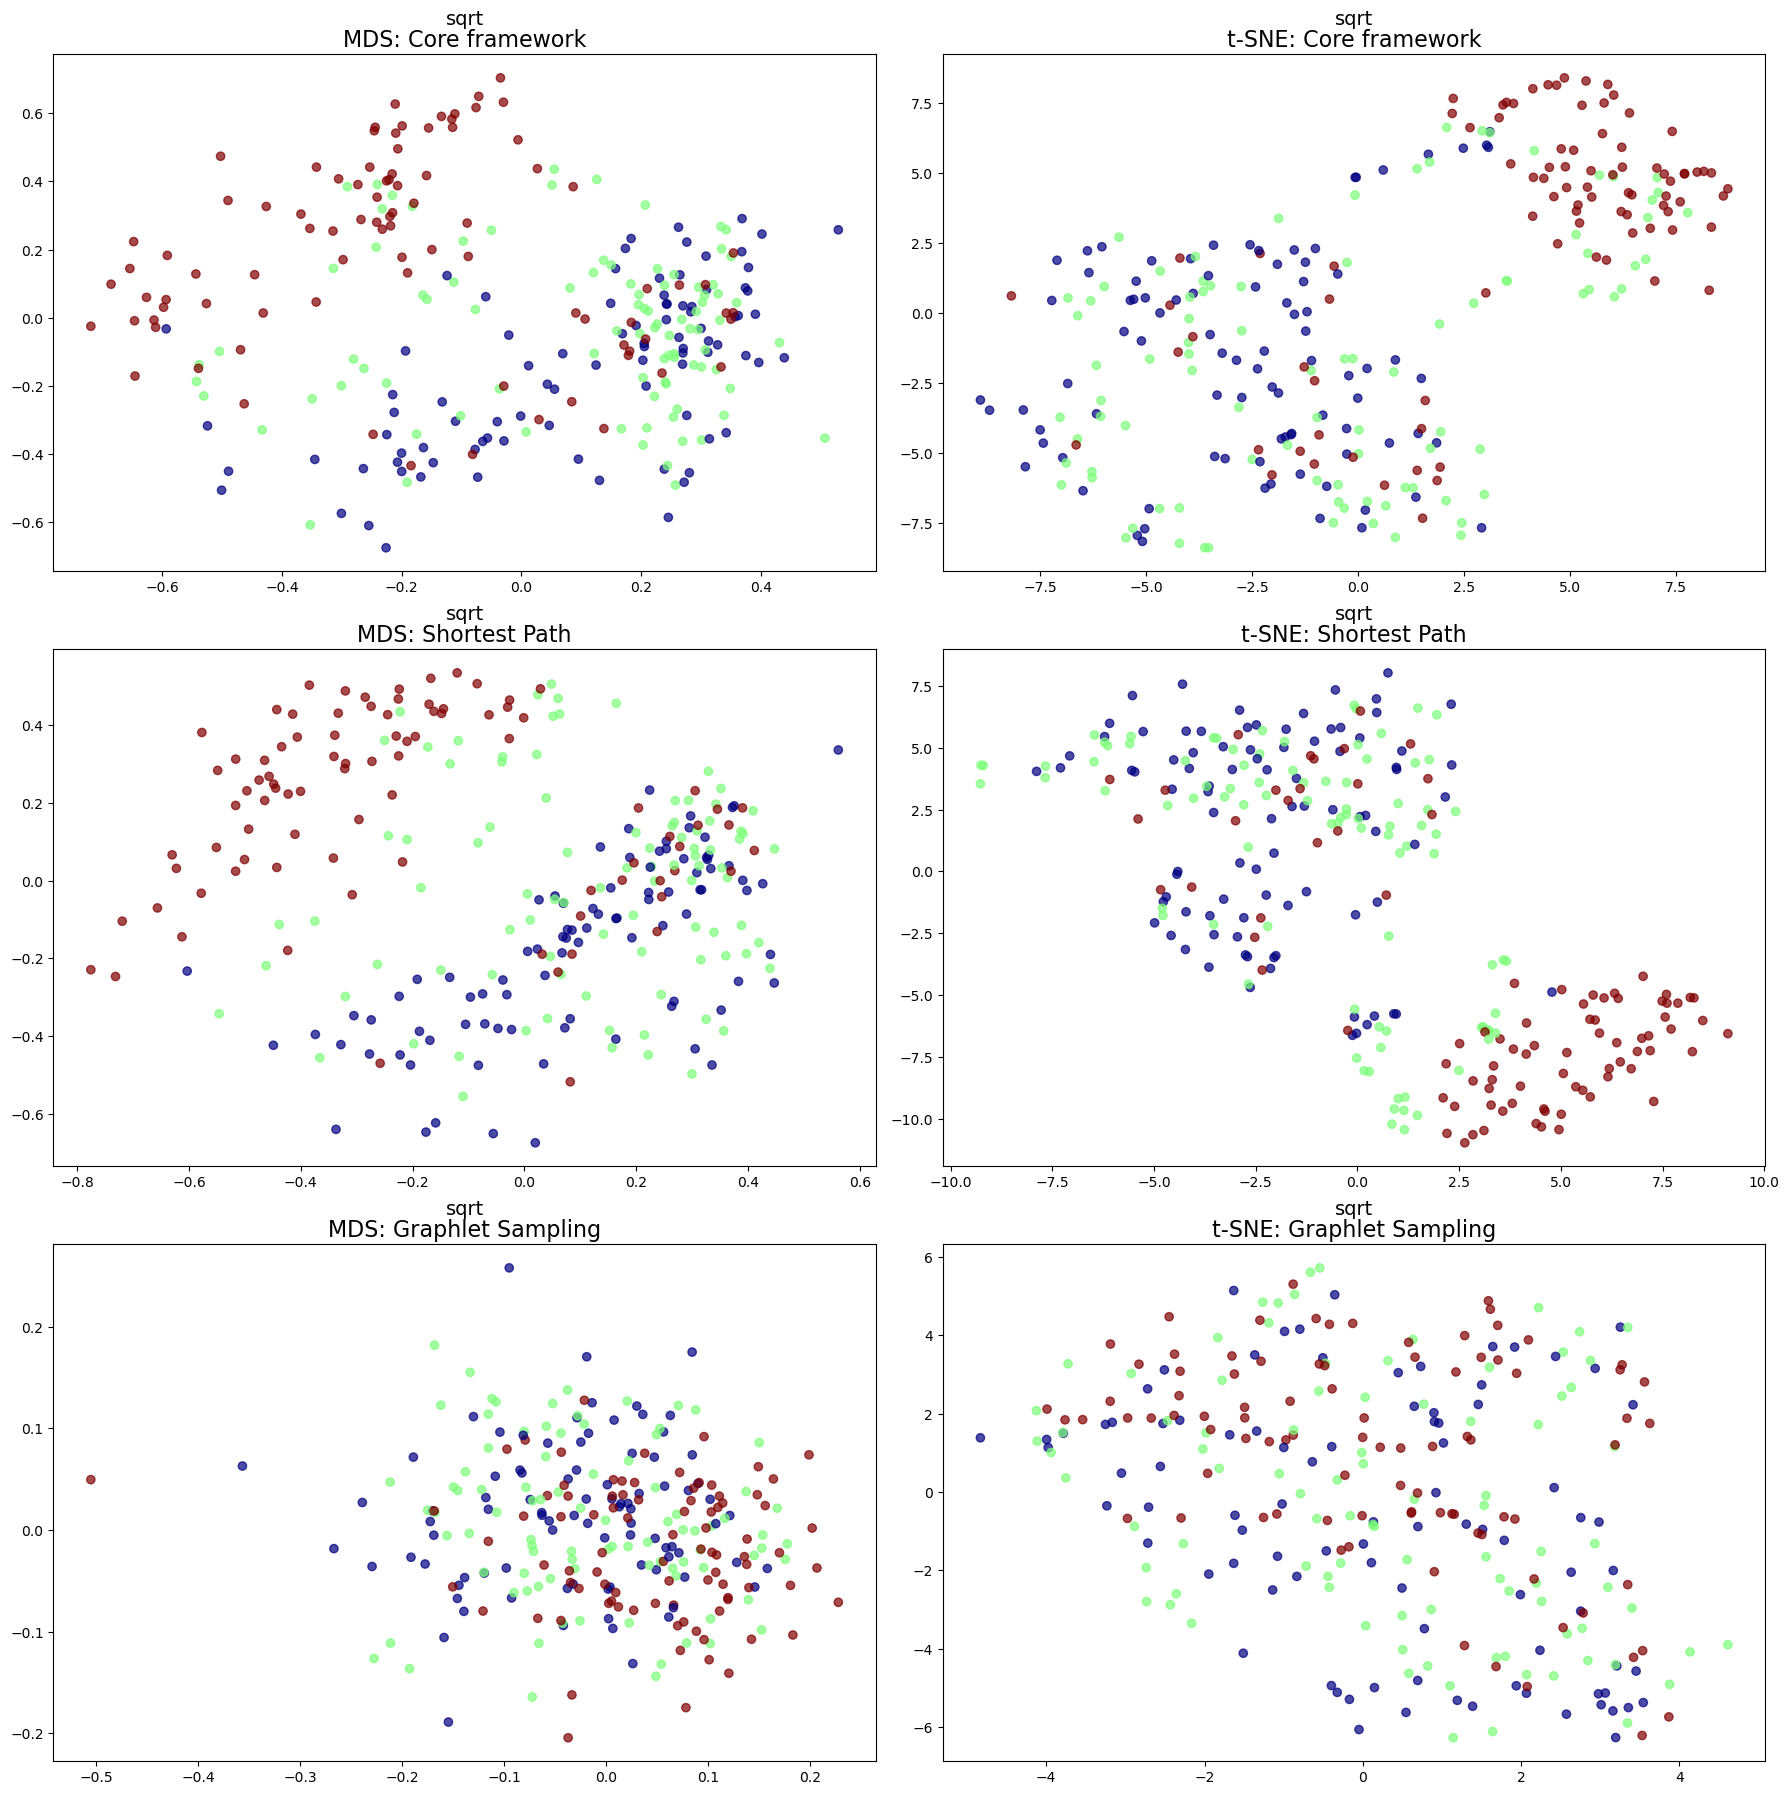

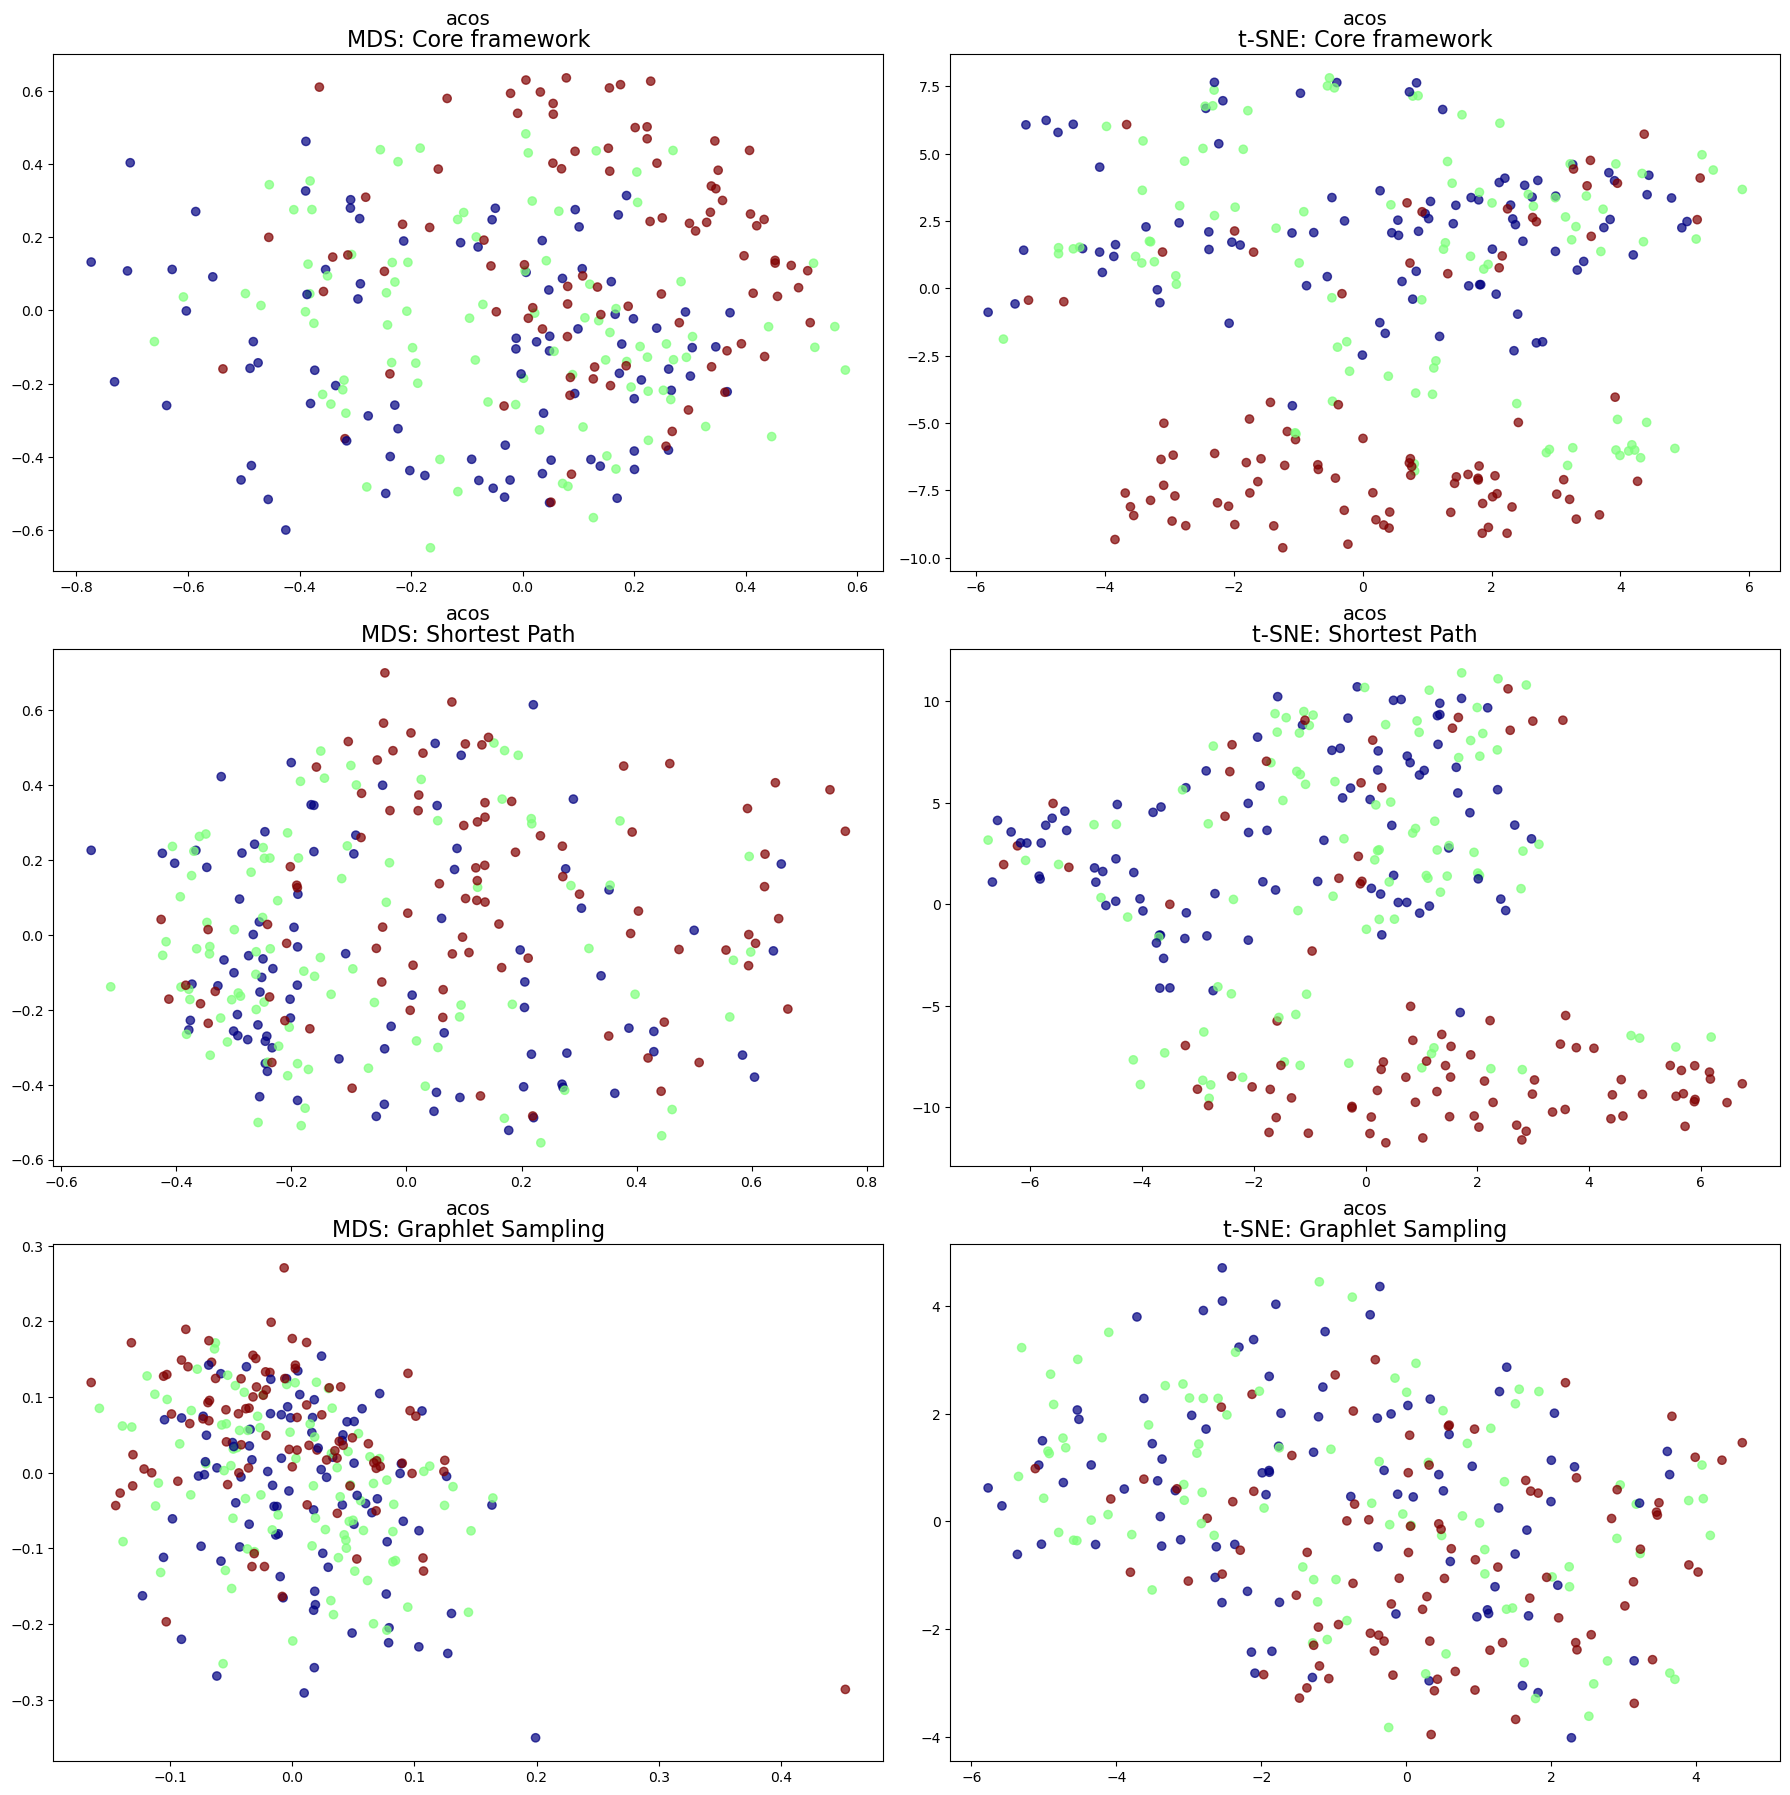

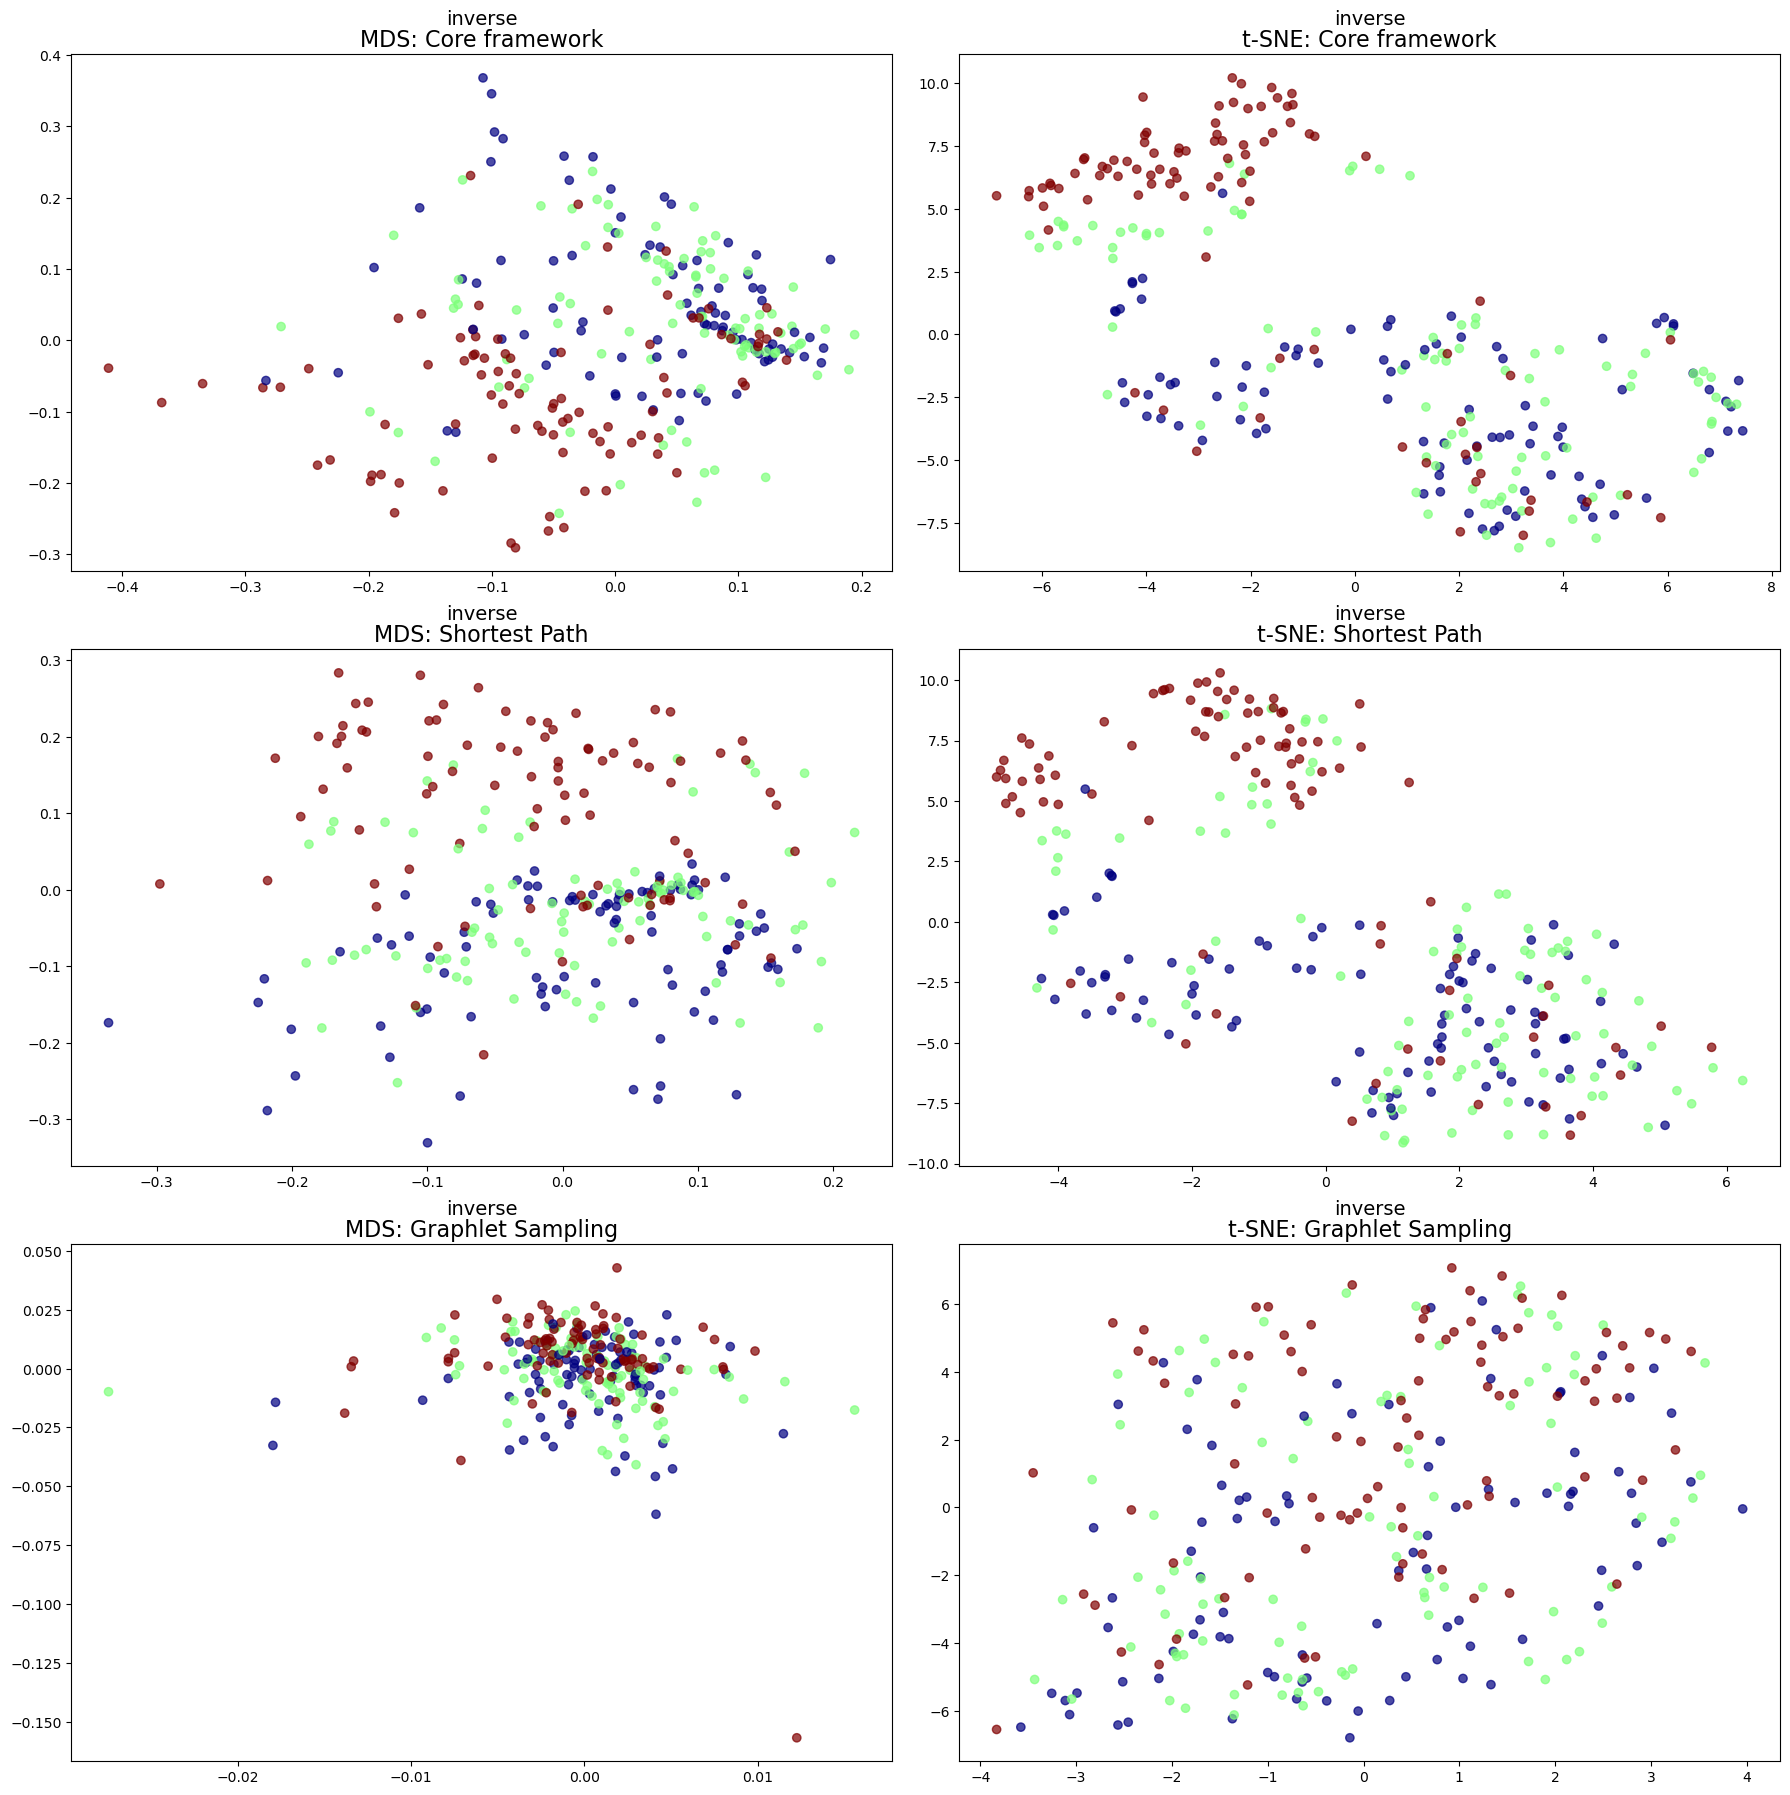

In [35]:
# визуализируем
for distance_method_name, distance_method in distance_methods.items():
    dist_mat = {}
    for name, K in ker_mat.items():
        dist_mat[name] = distance_method(K)

    embeddings = {}
    for method_name, embedder in embeddings_methods.items():
        embeddings[method_name] = {}
        for name, D in dist_mat.items():
            embeddings[method_name][name] = embedder.fit_transform(D)

    # Создание графиков
    fig, axes = plt.subplots(len(kernels), len(embeddings_methods), figsize=(18, 18))

    for i, (kernel_name, D) in enumerate(dist_mat.items()):
        for j, (method_name, embed_dict) in enumerate(embeddings.items()):
            ax = axes[i, j]
            ax.scatter(embed_dict[kernel_name][:, 0], embed_dict[kernel_name][:, 1], c=y, cmap="jet", alpha=0.7)
            ax.set_title(f"{method_name}: {kernel_name}", fontsize=16)
            ax.text(0.5, 1.05, f'{distance_method_name}', ha='center', va='bottom', fontsize=14, transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

Кажется, что наилучшие результаты показывает shortest path, graphlet sampling справляется не очень хорошо.
В большинстве случаев методы уменьшения размерности (MDS и t-SNE) хорошо разделяют классы.
В случае с методом acos и ядром Graphlet Sampling есть большее перекрытие классов, те есть сложности в разделении классов с помощью этого ядра.

Дополнительно: возьмите больше ядер и методов уменьшения размерности (4-5), комбинируйте ядра, как в прошлом дз и постарайтесь получить как можно более высокое качество классификации (можете взять больше измерений в эмбеддингах).

In [57]:
# загружаем данные из датасета hard_small, тк на датасете hard все алгоритмы очень долго работают
# поскольку в нем очень много значений

# загружаю данные по официальному примеру с репы grakel
loaded = np.load(f'hard_small.npz', allow_pickle=True)

A_train = list(loaded['tr_adj'])
X_train = loaded['tr_feat']
y_train = loaded['tr_class']
A_test = list(loaded['te_adj'])
X_test = loaded['te_feat']
y_test = loaded['te_class']

G_tr = []
for a, x in zip(A_train, X_train):
    G = nx.from_scipy_sparse_array(a)
    x_tuple = tuple(map(tuple, x))
    nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
    G_tr.append(G)

G_te = []
for a, x in zip(A_test, X_test):
    G = nx.from_scipy_sparse_array(a)
    x_tuple = tuple(map(tuple, x))
    nx.set_node_attributes(G, dict(enumerate(x_tuple)), 'features')
    G_te.append(G)

G_train = graph_from_networkx(G_tr, node_labels_tag='features')
G_train = [g for g in G_train]
y_train = np.argmax(y_train, axis=-1)
G_test = graph_from_networkx(G_te, node_labels_tag='features')
G_test = [g for g in G_test]
y_test = np.argmax(y_test, axis=-1)

G = G_train + G_test
y = np.concatenate((y_train, y_test))

In [58]:
from grakel.kernels import WeisfeilerLehman, NeighborhoodHash

kernels = {
    "shortest_path": ShortestPath(normalize=True),
    "graphlet_sampling": GraphletSampling(normalize=True),
    "neighborhood_hash": NeighborhoodHash(normalize=True),
    "core_framework": CoreFramework(normalize=True),
    "weisfeiler_lehman": WeisfeilerLehman(normalize=True),
}
ker_mat = {}
for kernel_name in kernels:
    kernel = kernels[kernel_name]
    ker_mat[kernel_name] = kernel.fit_transform(G)

In [59]:
from sklearn.decomposition import PCA
import umap.umap_ as umap

embeddings_methods = {
    "MDS": MDS(n_components=3, dissimilarity="precomputed"),
    "t-SNE": TSNE(n_components=3, metric="precomputed", init='random'),
    "PCA": PCA(n_components=3),
    "UMAP": umap.UMAP(n_components=3, metric="precomputed")
}

In [60]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


# оценим все комбинации
# Оценка точности для всех комбинаций
for distance_method_name, distance_method in distance_methods.items():
    dist_mat = {}
    for name, K in ker_mat.items():
        dist_mat[name] = distance_method(K)

    embeddings = {}
    for method_name, embedder in embeddings_methods.items():
        embeddings[method_name] = {}
        for name, D in dist_mat.items():
            embeddings[method_name][name] = embedder.fit_transform(D)

    for kernel_name in ker_mat:
        for method_name in embeddings_methods:
            dist_matrix = distance_method(ker_mat[kernel_name])  # Используем метод расстояния
            embedding = embeddings_methods[method_name].fit_transform(dist_matrix)
            # Преобразуем эмбеддинги в двумерные массивы для классификации
            X_train_final = embedding[:len(y_train)]  # Берем эмбеддинги для обучающей выборки
            X_test_final = embedding[len(y_train):]  # Берем эмбеддинги для тестовой выборки

            # Классификация с использованием RandomForest и LogisticRegression
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_model.fit(X_train_final, y_train)  # Используем X_train и y_train
            rf_pred = rf_model.predict(X_test_final)  # Применяем на тестовой выборке
            rf_accuracy = accuracy_score(y_test, rf_pred)  # Сравниваем с y_test

            lr_model = LogisticRegression(max_iter=1000, random_state=42)
            lr_model.fit(X_train_final, y_train)  # Используем X_train и y_train
            lr_pred = lr_model.predict(X_test_final)  # Применяем на тестовой выборке
            lr_accuracy = accuracy_score(y_test, lr_pred)  # Сравниваем с y_test

            # Выводим результаты для каждой сочетания
            print(f"Distance method: {distance_method_name}")
            print(f"Kernel: {kernel_name}, Embedding: {method_name}, Random Forest Accuracy: {rf_accuracy:.4f}, Logistic Regression Accuracy: {lr_accuracy:.4f}")

/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: usi

Distance method: sqrt
Kernel: shortest_path, Embedding: MDS, Random Forest Accuracy: 0.6154, Logistic Regression Accuracy: 0.5769
Distance method: sqrt
Kernel: shortest_path, Embedding: t-SNE, Random Forest Accuracy: 0.7692, Logistic Regression Accuracy: 0.6154
Distance method: sqrt
Kernel: shortest_path, Embedding: PCA, Random Forest Accuracy: 0.6154, Logistic Regression Accuracy: 0.6154


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: sqrt
Kernel: shortest_path, Embedding: UMAP, Random Forest Accuracy: 0.7308, Logistic Regression Accuracy: 0.4231
Distance method: sqrt
Kernel: graphlet_sampling, Embedding: MDS, Random Forest Accuracy: 0.3462, Logistic Regression Accuracy: 0.4231
Distance method: sqrt
Kernel: graphlet_sampling, Embedding: t-SNE, Random Forest Accuracy: 0.3846, Logistic Regression Accuracy: 0.3846
Distance method: sqrt
Kernel: graphlet_sampling, Embedding: PCA, Random Forest Accuracy: 0.4615, Logistic Regression Accuracy: 0.3077


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: sqrt
Kernel: graphlet_sampling, Embedding: UMAP, Random Forest Accuracy: 0.3077, Logistic Regression Accuracy: 0.3846
Distance method: sqrt
Kernel: neighborhood_hash, Embedding: MDS, Random Forest Accuracy: 0.2692, Logistic Regression Accuracy: 0.2692
Distance method: sqrt
Kernel: neighborhood_hash, Embedding: t-SNE, Random Forest Accuracy: 0.5385, Logistic Regression Accuracy: 0.3462
Distance method: sqrt
Kernel: neighborhood_hash, Embedding: PCA, Random Forest Accuracy: 0.3462, Logistic Regression Accuracy: 0.3077


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: sqrt
Kernel: neighborhood_hash, Embedding: UMAP, Random Forest Accuracy: 0.4615, Logistic Regression Accuracy: 0.3462
Distance method: sqrt
Kernel: core_framework, Embedding: MDS, Random Forest Accuracy: 0.5769, Logistic Regression Accuracy: 0.6538
Distance method: sqrt
Kernel: core_framework, Embedding: t-SNE, Random Forest Accuracy: 0.8077, Logistic Regression Accuracy: 0.6154
Distance method: sqrt
Kernel: core_framework, Embedding: PCA, Random Forest Accuracy: 0.6154, Logistic Regression Accuracy: 0.6154


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: sqrt
Kernel: core_framework, Embedding: UMAP, Random Forest Accuracy: 0.7692, Logistic Regression Accuracy: 0.5000
Distance method: sqrt
Kernel: weisfeiler_lehman, Embedding: MDS, Random Forest Accuracy: 0.3077, Logistic Regression Accuracy: 0.2308
Distance method: sqrt
Kernel: weisfeiler_lehman, Embedding: t-SNE, Random Forest Accuracy: 0.3462, Logistic Regression Accuracy: 0.2692
Distance method: sqrt
Kernel: weisfeiler_lehman, Embedding: PCA, Random Forest Accuracy: 0.2308, Logistic Regression Accuracy: 0.3077


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: sqrt
Kernel: weisfeiler_lehman, Embedding: UMAP, Random Forest Accuracy: 0.2692, Logistic Regression Accuracy: 0.3462


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: usi

Distance method: acos
Kernel: shortest_path, Embedding: MDS, Random Forest Accuracy: 0.5385, Logistic Regression Accuracy: 0.6154
Distance method: acos
Kernel: shortest_path, Embedding: t-SNE, Random Forest Accuracy: 0.7308, Logistic Regression Accuracy: 0.5000
Distance method: acos
Kernel: shortest_path, Embedding: PCA, Random Forest Accuracy: 0.6154, Logistic Regression Accuracy: 0.6154


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: acos
Kernel: shortest_path, Embedding: UMAP, Random Forest Accuracy: 0.6538, Logistic Regression Accuracy: 0.5385
Distance method: acos
Kernel: graphlet_sampling, Embedding: MDS, Random Forest Accuracy: 0.3846, Logistic Regression Accuracy: 0.3846
Distance method: acos
Kernel: graphlet_sampling, Embedding: t-SNE, Random Forest Accuracy: 0.3846, Logistic Regression Accuracy: 0.3462
Distance method: acos
Kernel: graphlet_sampling, Embedding: PCA, Random Forest Accuracy: 0.4231, Logistic Regression Accuracy: 0.3077


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: acos
Kernel: graphlet_sampling, Embedding: UMAP, Random Forest Accuracy: 0.4615, Logistic Regression Accuracy: 0.3462
Distance method: acos
Kernel: neighborhood_hash, Embedding: MDS, Random Forest Accuracy: 0.3077, Logistic Regression Accuracy: 0.1538
Distance method: acos
Kernel: neighborhood_hash, Embedding: t-SNE, Random Forest Accuracy: 0.2308, Logistic Regression Accuracy: 0.3077
Distance method: acos
Kernel: neighborhood_hash, Embedding: PCA, Random Forest Accuracy: 0.3077, Logistic Regression Accuracy: 0.3077


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: acos
Kernel: neighborhood_hash, Embedding: UMAP, Random Forest Accuracy: 0.5000, Logistic Regression Accuracy: 0.3077
Distance method: acos
Kernel: core_framework, Embedding: MDS, Random Forest Accuracy: 0.5769, Logistic Regression Accuracy: 0.6154
Distance method: acos
Kernel: core_framework, Embedding: t-SNE, Random Forest Accuracy: 0.6154, Logistic Regression Accuracy: 0.5385
Distance method: acos
Kernel: core_framework, Embedding: PCA, Random Forest Accuracy: 0.6154, Logistic Regression Accuracy: 0.6154


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: acos
Kernel: core_framework, Embedding: UMAP, Random Forest Accuracy: 0.6154, Logistic Regression Accuracy: 0.5000
Distance method: acos
Kernel: weisfeiler_lehman, Embedding: MDS, Random Forest Accuracy: 0.3077, Logistic Regression Accuracy: 0.2692
Distance method: acos
Kernel: weisfeiler_lehman, Embedding: t-SNE, Random Forest Accuracy: 0.1923, Logistic Regression Accuracy: 0.2308
Distance method: acos
Kernel: weisfeiler_lehman, Embedding: PCA, Random Forest Accuracy: 0.2308, Logistic Regression Accuracy: 0.3077


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: acos
Kernel: weisfeiler_lehman, Embedding: UMAP, Random Forest Accuracy: 0.2308, Logistic Regression Accuracy: 0.3462


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: usi

Distance method: inverse
Kernel: shortest_path, Embedding: MDS, Random Forest Accuracy: 0.5385, Logistic Regression Accuracy: 0.5385
Distance method: inverse
Kernel: shortest_path, Embedding: t-SNE, Random Forest Accuracy: 0.6538, Logistic Regression Accuracy: 0.6154
Distance method: inverse
Kernel: shortest_path, Embedding: PCA, Random Forest Accuracy: 0.5385, Logistic Regression Accuracy: 0.6154


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: inverse
Kernel: shortest_path, Embedding: UMAP, Random Forest Accuracy: 0.6923, Logistic Regression Accuracy: 0.5769
Distance method: inverse
Kernel: graphlet_sampling, Embedding: MDS, Random Forest Accuracy: 0.4231, Logistic Regression Accuracy: 0.1538
Distance method: inverse
Kernel: graphlet_sampling, Embedding: t-SNE, Random Forest Accuracy: 0.3846, Logistic Regression Accuracy: 0.3077
Distance method: inverse
Kernel: graphlet_sampling, Embedding: PCA, Random Forest Accuracy: 0.3462, Logistic Regression Accuracy: 0.3846


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: inverse
Kernel: graphlet_sampling, Embedding: UMAP, Random Forest Accuracy: 0.3846, Logistic Regression Accuracy: 0.3846
Distance method: inverse
Kernel: neighborhood_hash, Embedding: MDS, Random Forest Accuracy: 0.5000, Logistic Regression Accuracy: 0.3462
Distance method: inverse
Kernel: neighborhood_hash, Embedding: t-SNE, Random Forest Accuracy: 0.4615, Logistic Regression Accuracy: 0.4231
Distance method: inverse
Kernel: neighborhood_hash, Embedding: PCA, Random Forest Accuracy: 0.2692, Logistic Regression Accuracy: 0.3077


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: inverse
Kernel: neighborhood_hash, Embedding: UMAP, Random Forest Accuracy: 0.3846, Logistic Regression Accuracy: 0.3846
Distance method: inverse
Kernel: core_framework, Embedding: MDS, Random Forest Accuracy: 0.5000, Logistic Regression Accuracy: 0.5385
Distance method: inverse
Kernel: core_framework, Embedding: t-SNE, Random Forest Accuracy: 0.6538, Logistic Regression Accuracy: 0.5769
Distance method: inverse
Kernel: core_framework, Embedding: PCA, Random Forest Accuracy: 0.5385, Logistic Regression Accuracy: 0.6154


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: inverse
Kernel: core_framework, Embedding: UMAP, Random Forest Accuracy: 0.8077, Logistic Regression Accuracy: 0.4615
Distance method: inverse
Kernel: weisfeiler_lehman, Embedding: MDS, Random Forest Accuracy: 0.3077, Logistic Regression Accuracy: 0.3462
Distance method: inverse
Kernel: weisfeiler_lehman, Embedding: t-SNE, Random Forest Accuracy: 0.2692, Logistic Regression Accuracy: 0.3462
Distance method: inverse
Kernel: weisfeiler_lehman, Embedding: PCA, Random Forest Accuracy: 0.1538, Logistic Regression Accuracy: 0.3077


/Users/elizabeth/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


Distance method: inverse
Kernel: weisfeiler_lehman, Embedding: UMAP, Random Forest Accuracy: 0.1538, Logistic Regression Accuracy: 0.3846


Самый лучший результат дает комбинация inverse, core_framework, umap. При таких условиях accuracy RF = 0.8077
Также хорошие результаты у acos, shortest_path, t-SNE. accuracy RF = 0.7308
И такой же результат при комбинации sqrt, umap, shortest_path.